In [102]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
from scipy import ndimage

# Task 1

In [138]:
def binary_threshold(img, threshold):
    
    result = img.copy()
    
    result[img < threshold] = 0
    result[img >= threshold] = 255
    return result

In [ ]:
def adaptive_threshold_custom(image, block_size, C, method="mean"):
    # local statistics
    if method == "mean":
        local_mean = cv2.boxFilter(image, ddepth=-1, ksize=(block_size, block_size))
        local_thresh = local_mean - C
    elif method == "median":
        local_thresh = cv2.medianBlur(image, block_size) - C

    # Apply thresholding
    binary_image = (image > local_thresh).astype(np.uint8) * 255

    return binary_image

In [140]:
def otsu_threshold(image):   
    # Flatten the image to calculate histogram
    pixel_values = image.ravel()
    hist, _ = np.histogram(pixel_values, bins=256, range=(0, 256))
    

    total_pixels = pixel_values.size
    cumulative_sum = np.cumsum(hist)
    cumulative_mean = np.cumsum(hist * np.arange(256))
    global_mean = cumulative_mean[-1] / total_pixels 
    
    # Compute between-class variance for each threshold
    between_class_variance = (
        (global_mean * cumulative_sum - cumulative_mean)**2 / 
        (cumulative_sum * (total_pixels - cumulative_sum) + 1e-10)  # + to void division by zero
    )
    
    optimal_threshold = np.argmax(between_class_variance)
    
 
    binary_image = (image > optimal_threshold).astype(np.uint8) * 255
    
    return optimal_threshold, binary_image

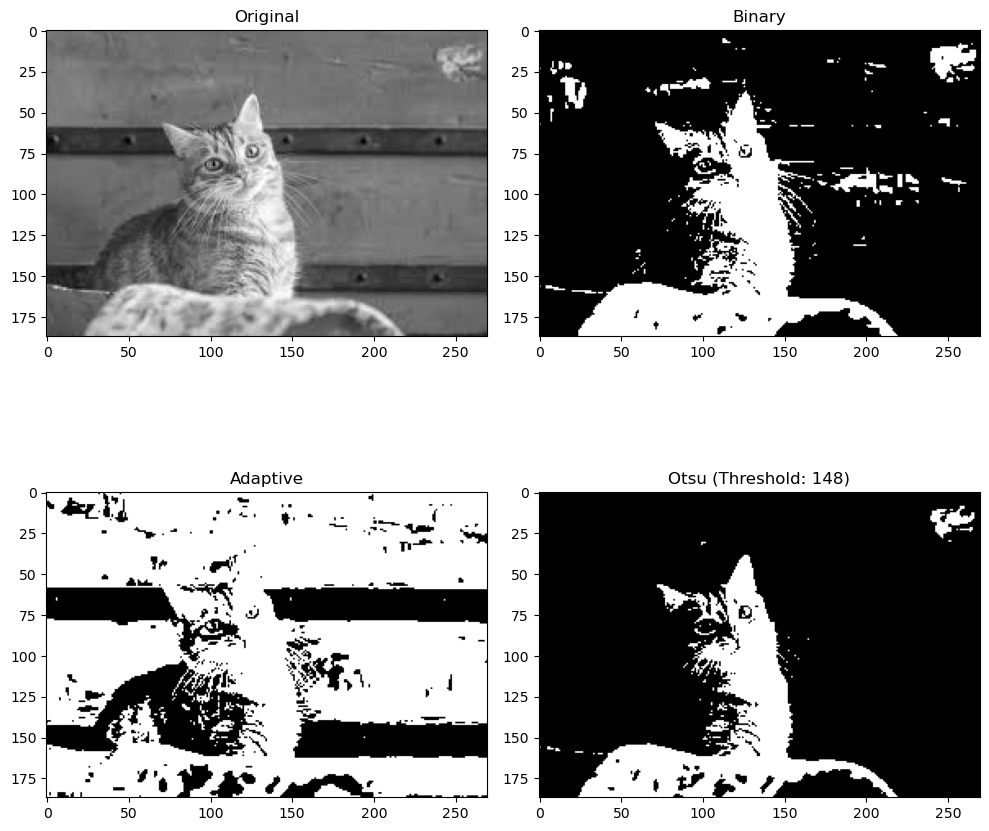

In [ ]:
cat = cv2.imread("./images/cat.jpg", cv2.IMREAD_GRAYSCALE)

# binary thresholding
cat_binary = binary_threshold(cat, 128)

# adaptive thresholding
C = 9
block_size = 77
cat_adaptive = adaptive_threshold_custom(cat, block_size, C, method="median")

# Otsu's thres holding
optimal_threshold, binary_image = otsu_threshold(cat)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(cat, cmap="gray")
plt.title(f"Original")

plt.subplot(2, 2, 2)
plt.imshow(cat_binary, cmap="gray")
plt.title(f"Binary")

plt.subplot(2, 2, 3)
plt.imshow(cat_adaptive, cmap="gray")
plt.title(f"Adaptive")

plt.subplot(2, 2, 4)
plt.imshow(binary_image, cmap='gray')
plt.title(f"Otsu (Threshold: {optimal_threshold})")

plt.tight_layout()
plt.show()

# Task 2

In [22]:
def hough_transform(edges, rho=1, theta=360, threshold=130):
    height, width = edges.shape
    diagonal = int(np.sqrt(height**2 + width**2))
    
    # Calculate number of rho and theta bins
    num_rhos = int(2 * diagonal / rho)
    num_thetas = int(theta / np.pi)
    
    # Create Hough space
    thetas = np.linspace(-np.pi/2, np.pi/2, num_thetas)
    rhos = np.linspace(-diagonal, diagonal, num_rhos)
    
    cos_thetas = np.cos(thetas)
    sin_thetas = np.sin(thetas)
    
    accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
    
    y_idxs, x_idxs = np.nonzero(edges)
    
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for theta_idx in range(len(thetas)):
            r = int((x * cos_thetas[theta_idx] + y * sin_thetas[theta_idx] + diagonal) / rho)
            accumulator[r, theta_idx] += 1
    
    lines = []
    for rho_idx in range(accumulator.shape[0]):
        for theta_idx in range(accumulator.shape[1]):
            if accumulator[rho_idx, theta_idx] > threshold:
                rho_val = rhos[rho_idx]
                theta_val = thetas[theta_idx]
                lines.append((rho_val, theta_val))
    
    return lines

In [84]:
def detect_and_highlight_lines(image, low_threshold=50, high_threshold=150, rho = 1, theta = 360, hough_threshold=100):
    # Convert to grayscale if necessary
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Apply Canny edge detection
    edges = cv2.Canny(image, low_threshold, high_threshold)

    # Perform morphological closing
    # kernel = np.ones((2, 2), np.uint8)
    # edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # Apply Hough Transform
    lines = hough_transform(edges,rho, theta, hough_threshold)
    
    # Highlight detected lines
    result = image.copy()
    for rho, theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(result, (x1, y1), (x2, y2), (0, 0, 255), 1)
    
    return result, edges

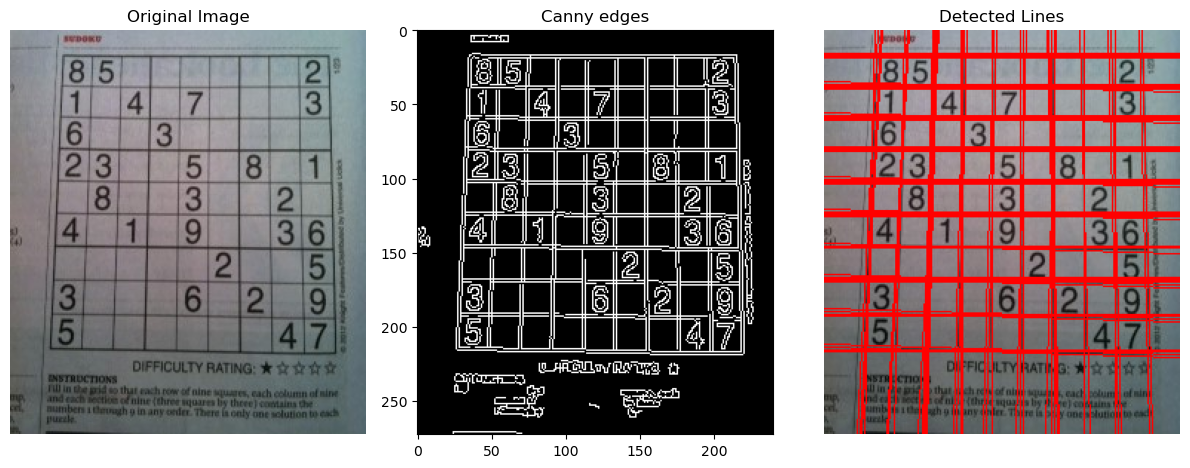

In [95]:
image_path = './images/sudoku.jpg'  # Replace with your image path
sudoku = cv2.imread(image_path)

result, edges = detect_and_highlight_lines(sudoku, low_threshold=100, high_threshold=300, rho = 1, theta = 400, hough_threshold=100)

plt.figure(figsize=(12, 6))
plt.subplot(131), plt.imshow(sudoku[...,::-1])
plt.title('Original Image'), plt.axis('off')
plt.subplot(132), plt.imshow(edges, cmap='gray')
plt.title("Canny edges")
plt.subplot(133), plt.imshow(result[...,::-1])
plt.title('Detected Lines'), plt.axis('off')
plt.tight_layout()
plt.show()

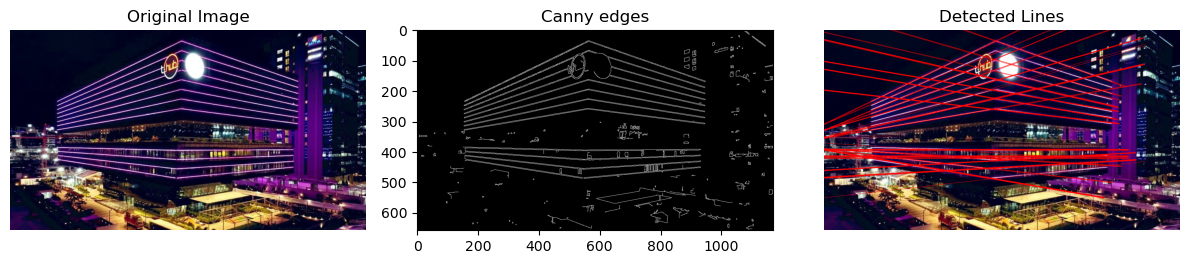

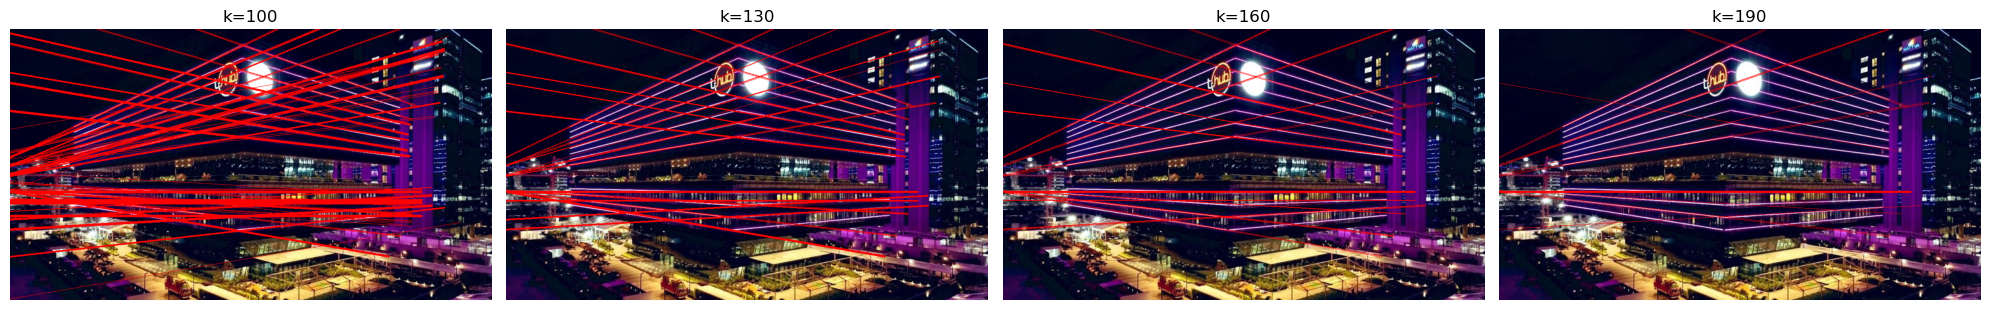

In [100]:
image_path = './images/thub.jpg'  # Replace with your image path
thub = cv2.imread(image_path)

result, edges = detect_and_highlight_lines(thub, low_threshold=300, high_threshold=900, rho = 1, theta = 180, hough_threshold=120)

plt.figure(figsize=(12, 6))
plt.subplot(131), plt.imshow(thub[...,::-1])
plt.title('Original Image'), plt.axis('off')
plt.subplot(132), plt.imshow(edges, cmap='gray')
plt.title("Canny edges")
plt.subplot(133), plt.imshow(result[...,::-1])
plt.title('Detected Lines'), plt.axis('off')
plt.tight_layout()
plt.show()

k_values = [100, 130, 160, 190]
fig, axes = plt.subplots(1, len(k_values), figsize=(20, 10))

for idx, k in enumerate(k_values):
    result, edges = detect_and_highlight_lines(thub, low_threshold=300, high_threshold=900, rho = 1, theta = 180, hough_threshold=k)
    
    # axes[0, idx].imshow(edges, cmap='gray')
    # axes[0, idx].set_title(f'k={k}')
    # axes[0, idx].axis('off')
    
    axes[idx].imshow(result[...,::-1])
    axes[idx].set_title(f'k={k}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

Increasing the threshold parameter reduces the number of detected lines, as only those lines that receive a higher number of votes (i.e., points along the line) are considered valid; this can lead to missing shorter or less prominent lines in the image. Conversely, decreasing the threshold allows for more lines to be detected, including those that are shorter or less distinct, but may also introduce more noise and false positives, as more line candidates are accepted.

This is clearly visible in the above image where as K increases the number of lines decreases and only the prominent lines are shown

# Task 3

In [134]:
def hough_circles(image, dp=1, minDist=30, canny_param=100, accumulator_threshold=100, minRadius=20, maxRadius=100):

    # Apply Canny edge detection
    edges = cv2.Canny(image, canny_param // 2, canny_param)
    
    h, w = edges.shape
    accumulator_h, accumulator_w = int(h / dp), int(w / dp)
    
    if maxRadius == 0:
        maxRadius = min(h, w) // 2
    if minRadius == 0:
        minRadius = 1
    
    radii = np.arange(minRadius, maxRadius + 1)
    num_radii = len(radii)
    
    accumulator = np.zeros((accumulator_h, accumulator_w, num_radii), dtype=np.int32)
    
    y, x = np.where(edges > 0)
    
    t = np.linspace(0, 2*np.pi, 180)
    cos_t = np.cos(t)
    sin_t = np.sin(t)
    
    for i, r in enumerate(radii):
        x_idxs = ((x[:, np.newaxis] - r * cos_t) / dp).astype(int)
        y_idxs = ((y[:, np.newaxis] - r * sin_t) / dp).astype(int)
        
        valid = (x_idxs >= 0) & (x_idxs < accumulator_w) & (y_idxs >= 0) & (y_idxs < accumulator_h)
        np.add.at(accumulator[:,:,i], (y_idxs[valid], x_idxs[valid]), 1)
    
    threshold = accumulator_threshold
    
    # Use maximum filter for local maxima
    size = (3, 3, 3)
    local_max = (accumulator == ndimage.maximum_filter(accumulator, size=size)) & (accumulator > threshold)
    
    circles = []
    for y, x, r in np.argwhere(local_max):
        center = (int(x * dp), int(y * dp))
        radius = radii[r]
        circles.append((center[0], center[1], radius))
    
    # Apply minimum distance criterion
    circles = np.array(circles)
    if len(circles) > 0:
        circles = circles[np.argsort(circles[:, 2])[::-1]]  # Sort by radius (descending)
        final_circles = []
        for circle in circles:
            if all(np.linalg.norm(circle[:2] - c[:2]) >= minDist for c in final_circles):
                final_circles.append(circle)
        circles = np.array(final_circles)
    
    return circles

[[376 166  42]
 [201 282  38]
 [280 119  37]
 [604 182  36]
 [564 301  35]
 [ 61 233  35]
 [185 193  34]
 [402  93  33]
 [285 235  33]
 [274 321  33]
 [441 357  33]
 [486 234  33]
 [540 370  32]]
num circles =  13


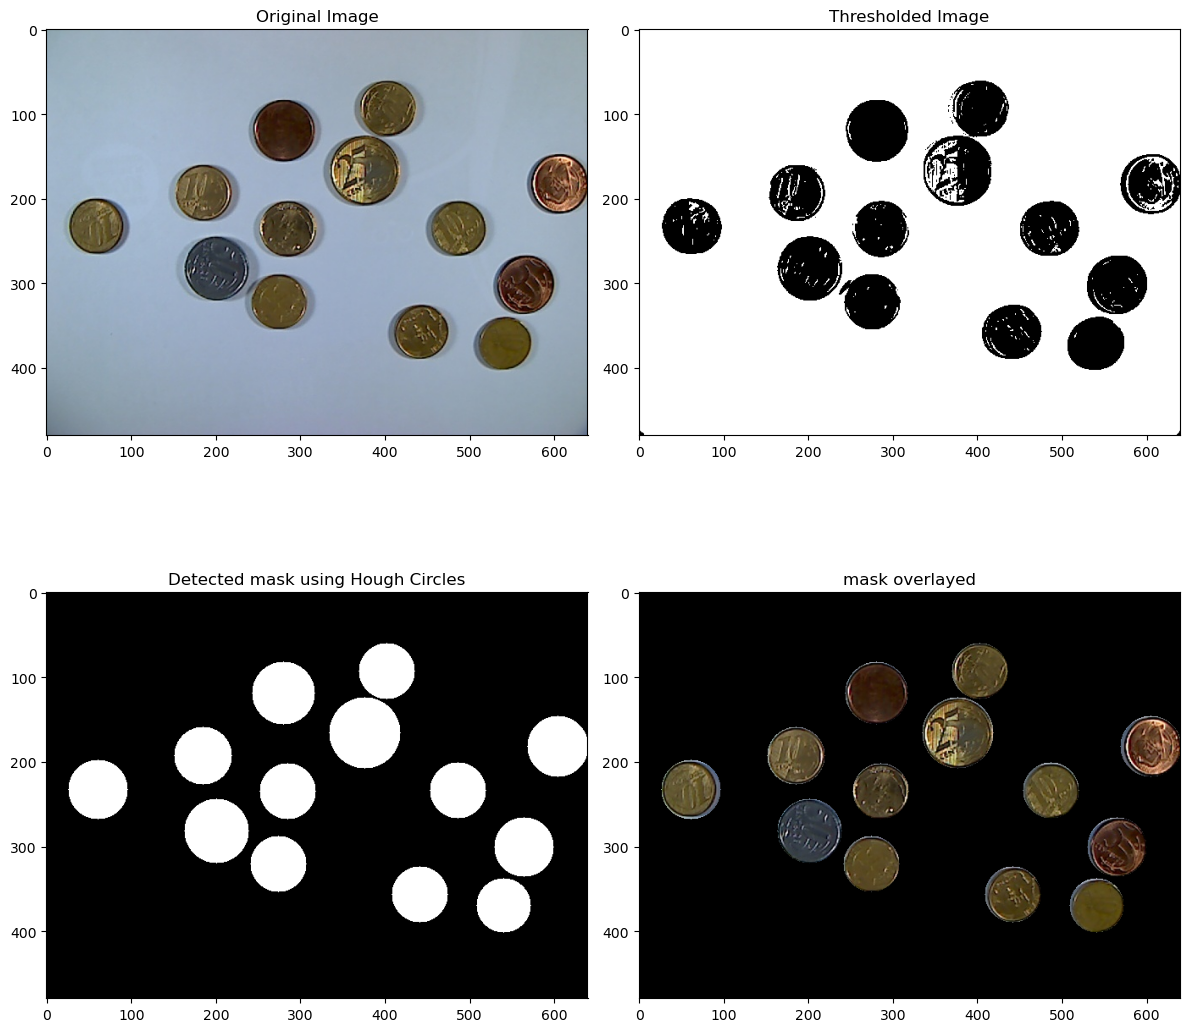

In [135]:
img = cv2.imread('./images/coin-detection.jpg')
# img = cv2.resize(img, (0, 0), fx=0.25, fy=0.25)

_, img_thresholded = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

circles = hough_circles(img_thresholded, dp=1, minDist=30, canny_param=1, accumulator_threshold=70, minRadius=20, maxRadius=80)

mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

print(circles)
for circle in circles.astype(int):
    x , y , r = [circle[0],circle[1],circle[2]]
    cv2.circle(mask, (x, y), r, 255, -1)



print("num circles = ",circles.shape[0])
result = np.zeros_like(img)
result[mask != 0, :] = img[mask != 0, :]

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.imshow(img[...,::-1])
plt.title('Original Image')

plt.subplot(222)
plt.imshow(img_thresholded, cmap='gray')
plt.title('Thresholded Image')

plt.subplot(223)
plt.imshow(mask, cmap='gray')
plt.title('Detected mask using Hough Circles')

plt.subplot(224)
plt.imshow(result[...,::-1])
plt.title('mask overlayed')

plt.tight_layout()
plt.show()

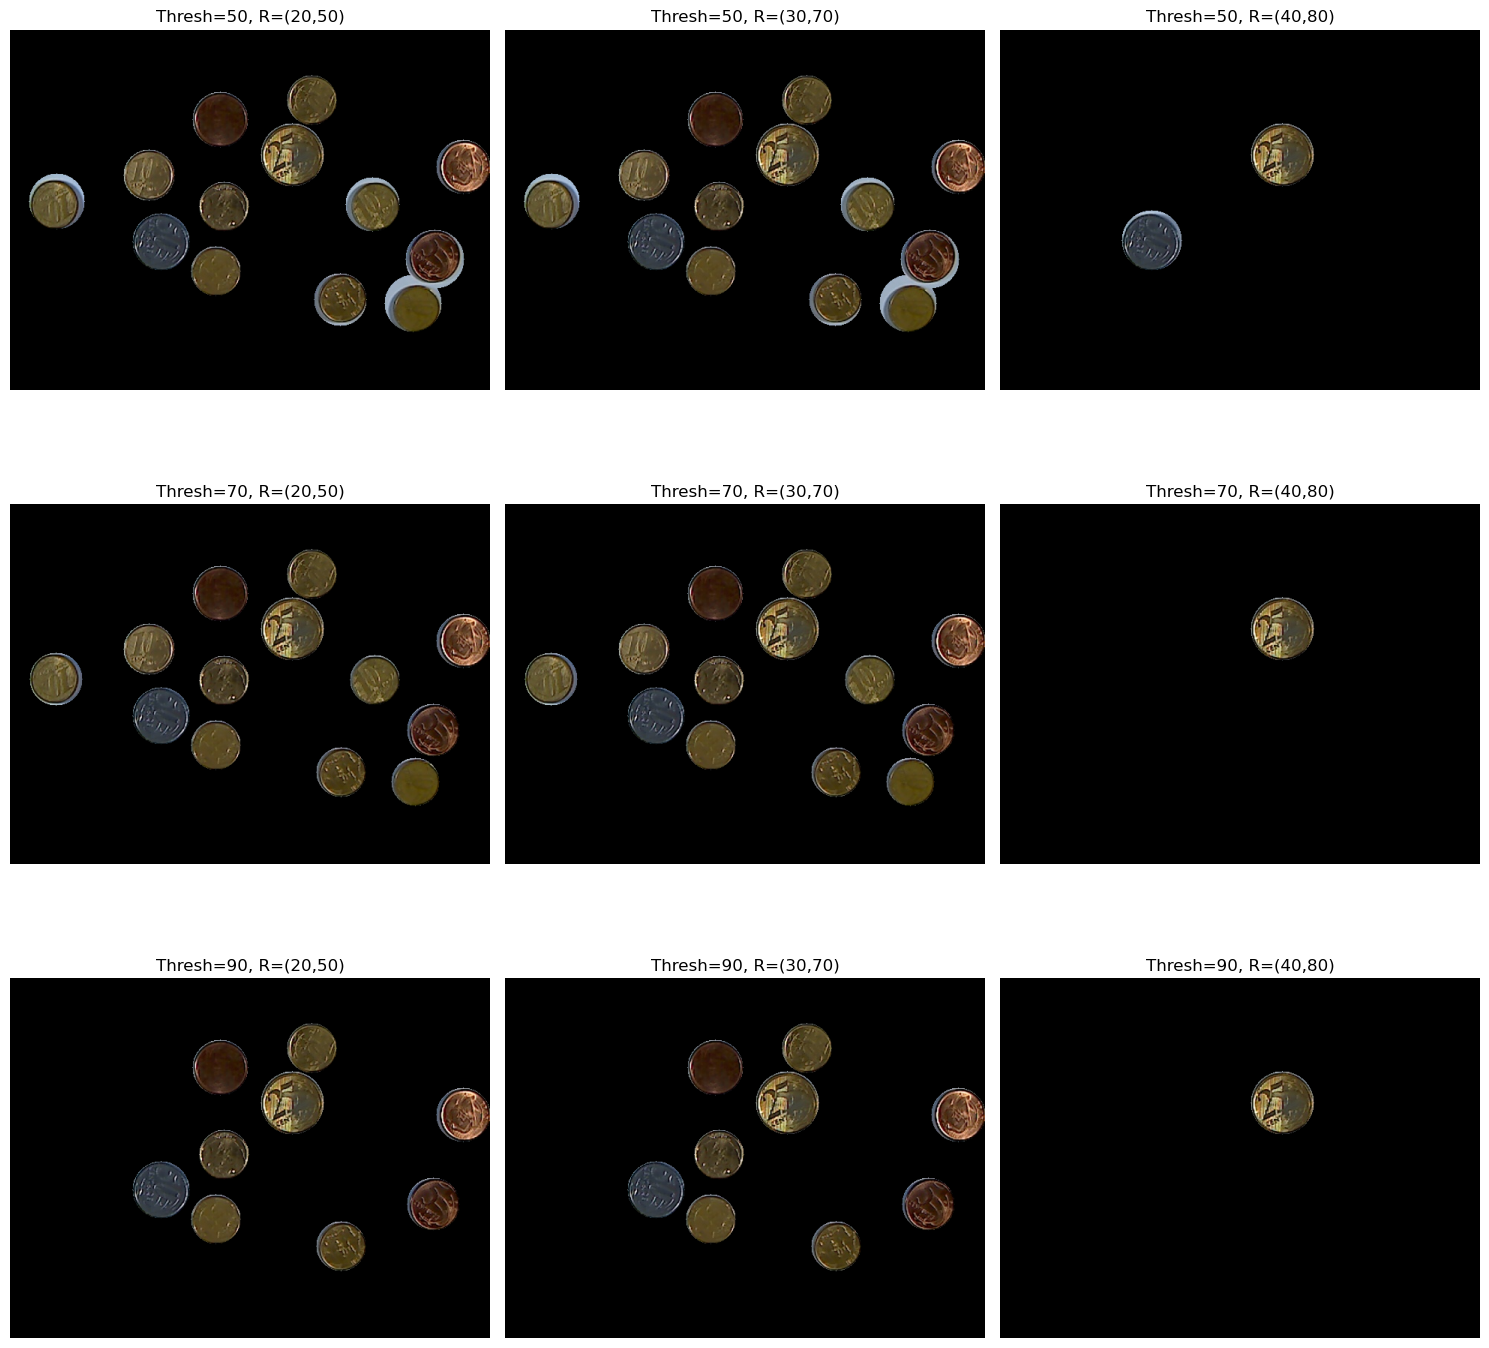

In [136]:
img = cv2.imread('./images/coin-detection.jpg')
# img = cv2.resize(img, (0, 0), fx=0.25, fy=0.25)

_, img_thresholded = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

accumulator_threshold_values = [50, 70, 90]
radius_ranges = [(20, 50), (30, 70), (40, 80)]

fig, axes = plt.subplots(len(accumulator_threshold_values), len(radius_ranges), figsize=(15, 15))

for i, acc_thresh in enumerate(accumulator_threshold_values):
    for j, (min_radius, max_radius) in enumerate(radius_ranges):
        circles = hough_circles(img_thresholded, dp=1, minDist=30, canny_param=1, accumulator_threshold=acc_thresh, minRadius=min_radius, maxRadius=max_radius)
        
        mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for circle in circles.astype(int):
            x, y, r = circle
            cv2.circle(mask, (x, y), r, 255, -1)
        
        result = np.zeros_like(img)
        result[mask != 0, :] = img[mask != 0, :]
        
        axes[i, j].imshow(result[..., ::-1])
        axes[i, j].set_title(f'Thresh={acc_thresh}, R=({min_radius},{max_radius})')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

# Task 4

In [27]:
def harris_corner_detection(image, k=0.04, threshold=0.01, nms_window_size=5):

    # He took this simple idea to a mathematical form. It basically finds the
    # difference in intensity for a displacement of (u,v) in all directions

    # E(u,v) = Σ Σ w(x,y) [I(x+u, y+v) - I(x,y)]^2 ; with w being the window function, and I is the intensity
    # The window function is either a rectangular window or a Gaussian window which gives weights to pixels underneath.
    # we need to maximize this E(u,v) function.


    # Convert the image to float32
    gray = np.float32(image)
    
    # # Compute Harris corner response
    # dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=k)
    
    # Compute gradients
    Ix = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    
    # Compute products of derivatives
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy
    
    
    # Compute the sums of the products of derivatives at each pixel
    Sxx = cv2.GaussianBlur(Ixx, (3, 3), 1)
    Syy = cv2.GaussianBlur(Iyy, (3, 3), 1)
    Sxy = cv2.GaussianBlur(Ixy, (3, 3), 1)
    
    # Compute the response of the detector at each pixel
    det = (Sxx * Syy) - (Sxy * Sxy)
    trace = Sxx + Syy
    dst = det - k * (trace ** 2)
    
    
    
    # Normalize the corner response
    # dst = np.empty(dst.shape, dtype=np.float32)
    # dst = cv2.normalize(dst, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    
    # Apply threshold and non-maximum suppression
    corners = np.zeros_like(dst)
    h, w = dst.shape
    for i in range(h):
        for j in range(w):
            if int(dst[i,j]) > threshold * dst.max():
                # Apply non-maximum suppression
                window = dst[max(0, i-nms_window_size//2):min(h, i+nms_window_size//2+1),
                                  max(0, j-nms_window_size//2):min(w, j+nms_window_size//2+1)]
                if dst[i,j] == window.max():
                    corners[i,j] = 255
    
    
    
    # Dilate corners for better visibility
    corners = cv2.dilate(corners, None)
    
    # Create a color image to mark corners
    marked_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Mark corners on the original image
    marked_image[corners > 0.01 * corners.max()] = [0, 0, 255]  # Red color
    
    return marked_image, corners

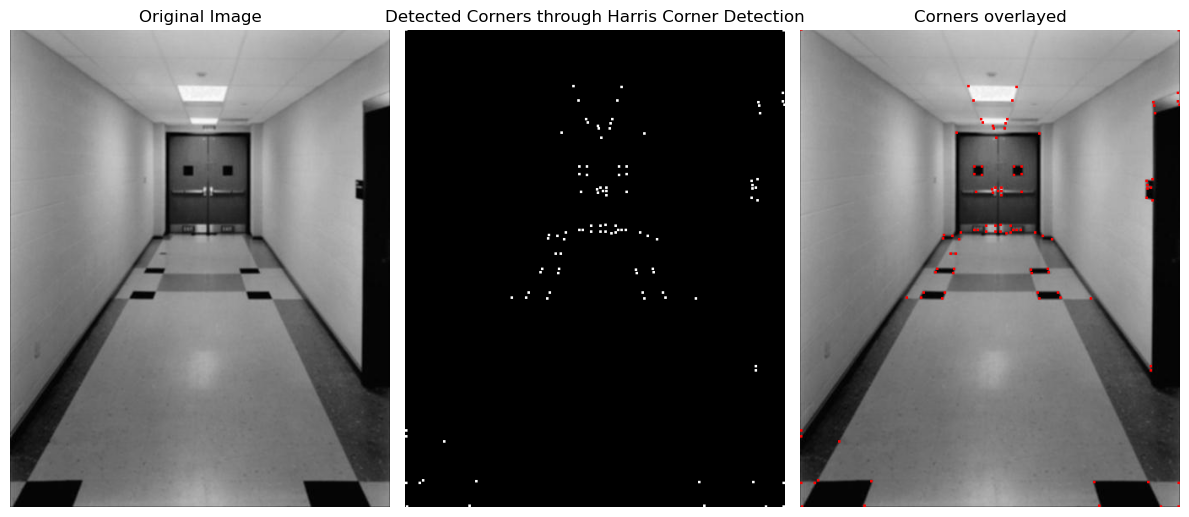

In [28]:
# Load the image
# image_path = './images/chessboard.jpg' 
# chessboard_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

image_path = './images/hallway.jpg' 
hallway_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

result, corners = harris_corner_detection(cv2.cvtColor(hallway_image, cv2.COLOR_BGR2GRAY),  k=0.04, threshold=0.01, nms_window_size=5)

# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(131), plt.imshow(hallway_image[...,::-1])
plt.title('Original Image'), plt.axis('off')
plt.subplot(132), plt.imshow(corners, cmap='gray')
plt.title('Detected Corners through Harris Corner Detection'), plt.axis('off')
plt.subplot(133), plt.imshow(result[...,::-1])
plt.title('Corners overlayed'), plt.axis('off')
plt.tight_layout()
plt.show()


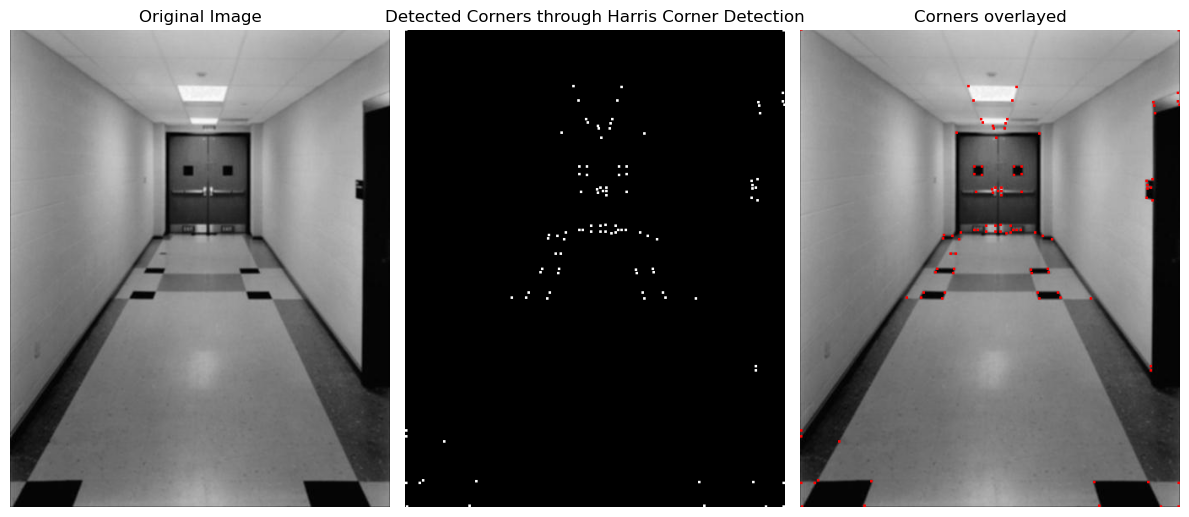

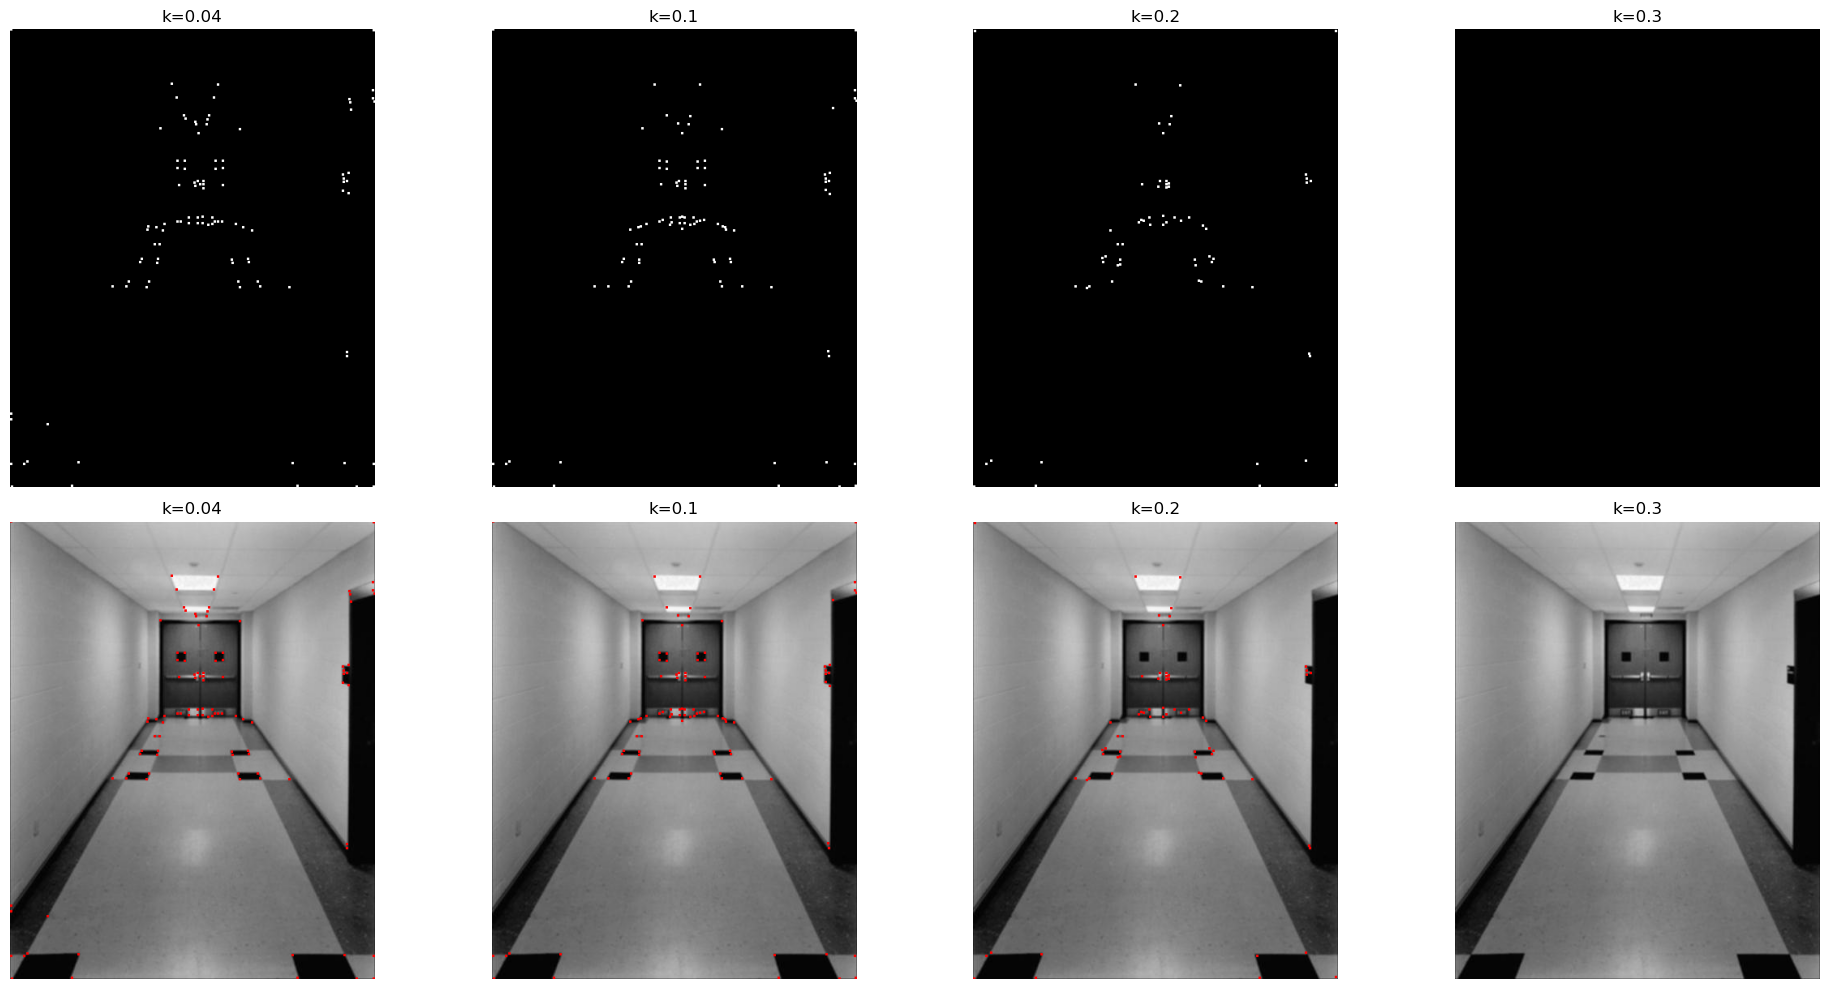

In [30]:
result, corners = harris_corner_detection(cv2.cvtColor(hallway_image, cv2.COLOR_BGR2GRAY),  k=0.04, threshold=0.01, nms_window_size=5)

# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(131), plt.imshow(hallway_image[...,::-1])
plt.title('Original Image'), plt.axis('off')
plt.subplot(132), plt.imshow(corners, cmap='gray')
plt.title('Detected Corners through Harris Corner Detection'), plt.axis('off')
plt.subplot(133), plt.imshow(result[...,::-1])
plt.title('Corners overlayed'), plt.axis('off')
plt.tight_layout()
plt.show()
# Vary the sensitivity parameter k and observe the results
k_values = [0.04, 0.1, 0.2, 0.3]
fig, axes = plt.subplots(2, len(k_values), figsize=(20, 10))

for idx, k in enumerate(k_values):
    result, corners = harris_corner_detection(cv2.cvtColor(hallway_image, cv2.COLOR_BGR2GRAY), k=k, threshold=0.01, nms_window_size=5)
    
    axes[0, idx].imshow(corners, cmap='gray')
    axes[0, idx].set_title(f'k={k}')
    axes[0, idx].axis('off')
    
    axes[1, idx].imshow(result[...,::-1])
    axes[1, idx].set_title(f'k={k}')
    axes[1, idx].axis('off')

plt.tight_layout()
plt.show()

It is a constant used in the calculation of the corner response function, influencing how much emphasis is placed on corner-like regions versus edge-like or flat regions. Typically, k is a value between 0.04 and 0.06. A lower k leads to more corners being detected, including noise, while a higher k makes the detector more selective, detecting only the most prominent corners and ignoring weak ones

Higher k => higher sensitivity => only prominent conners detected


This can also be seen in our results where the k=0.04 detected the 4 corners of the ceiling lamp, but k = 0.1 detected only 1. and even k = 0.1 detected  the corners in the door's black box, but k = 0.2 failed to do so. And k = 0.3 didnt detect anything

# Task 5

## Parameter Space

- **Line Detection**: The Hough Transform for lines operates in a two-dimensional parameter space. Each line can be represented in polar coordinates as $\rho = x \cos(\theta) + y \sin(\theta)$, where $\rho$ is the distance from the origin to the line and $\theta$ is the angle of the line. Each edge point in the image contributes to a sinusoidal curve in this space, and intersections of these curves indicate potential lines.

- **Circle Detection**: In contrast, circle detection requires a three-dimensional parameter space defined by the center coordinates $(x_{center}, y_{center})$ and radius $r$. For each edge point, a sphere is formed in this space, where the radius varies. The accumulator matrix collects votes for potential circles, with local maxima indicating detected circles.

## Computational Complexity

The computational complexity differs notably between the two applications:

- **Lines**: The two-dimensional nature of line detection leads to lower computational demands. The algorithm typically involves fewer calculations, making it faster and less memory-intensive.

- **Circles**: Circle detection's three-dimensional parameter space increases complexity significantly. The algorithm must evaluate multiple radii for each edge point, leading to higher computational overhead. This results in longer processing times and greater memory requirements due to the larger accumulator matrix needed to store votes for various circle parameters.

In summary, while both applications utilize the Hough Transform's voting mechanism, line detection is simpler and more efficient compared to the more complex and resource-intensive process required for circle detection.
